In [1]:
import json
import os
import pickle
import yaml

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from src.preprocessing.old_utils import evaluate
from src.preprocessing.preprocessing import get_Xy_from_sheet, spacy_preprocess_texts
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)
model_save_path = config["model_save_path"]
result_save_path = config["result_save_path"]

preproc = config["preprocessing"]["type"]

data_path = config["data_path"]
results_prefix = './test/results/'



# Create DataFrame and new column for analysis
X, y = get_Xy_from_sheet(data_path, X_col='Original article text', y_col='Verdict')

# x_transform, nlp = spacy_preprocess_texts(X, 'test1', 'md')

# vectors = [nlp.vocab.vectors.key2row[word.norm] if word.has_vector and word.norm in nlp.vocab.vectors.key2row else None for word in x_transform[0]]
# print(vectors)
# print(nlp.vocab.vectors.key2row)

# Preprocessing TODO: 
# n-gram

# spacy preprocessing: lemma, stem, etc
# Remove punct, nums

# Find way to incorporate sentence structure
# Include parts of speech


if config['preprocessing']['type'] == 'tfidf':
    tfidf = TfidfVectorizer(ngram_range=(config['preprocessing']['ngram_min'], config['preprocessing']['ngram_max']))
    X_transform = tfidf.fit_transform(X)

    idx2word = {idx: word for word, idx in tfidf.vocabulary_.items()}

else:
    cv = CountVectorizer(ngram_range=(config['preprocessing']['ngram_min'], config['preprocessing']['ngram_max']))
    X_transform = cv.fit_transform(X)

    idx2word = {idx: word for word, idx in cv.vocabulary_.items()}

X_train, X_test, y_train, y_test = train_test_split(X_transform, y, shuffle=True, random_state=42)


models = {
    'logistic-regression': LogisticRegression(),
    'svm': SVC(kernel='linear'),
    'decision-tree': DecisionTreeClassifier(),
    'random-forest': RandomForestClassifier(),
}

# LogReg, Decision Trees, Random Forests, SVMs

dataset_name = data_path.split('.')[0].split('/')[-1]

for model_name, model in models.items():
    fname = dataset_name + '_' + model_name
    pklname = model_save_path + fname + '.pkl'

    if pklname not in os.listdir(model_save_path):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        pickle.dump(model, open(pklname, 'wb'))

    else:
        model = pickle.load(open(pklname, 'rb'))
    print(model_name)
    acc, prec, recall = evaluate(y_test, preds)

    if model_name in ['logistic-regression', 'svm']:
        coefs = model.coef_[0]
        if model_name == 'svm':
            coefs = coefs.toarray().reshape((-1,))
        

    elif model_name in ['decision-tree', 'random-forest']:
        coefs = model.feature_importances_

    coefs = [(coef, i) for i, coef in enumerate(coefs)]
    coefs.sort(key=lambda x: x[0] ** 2, reverse=True)

    num_words = config['output']['num_words']
    most_important_words = {idx2word[idx]: coef for coef, idx in coefs[:num_words]}

    if config['output']['print']: print(f'Most important words for {model_name}: {most_important_words}')

    resultname = result_save_path + fname + '_' + preproc + '.json'
    with open(resultname, 'w') as f:
        json.dump(most_important_words, f)



logistic-regression
              precision    recall  f1-score   support

       False       0.57      0.94      0.71        36
        True       0.85      0.30      0.44        37

    accuracy                           0.62        73
   macro avg       0.71      0.62      0.57        73
weighted avg       0.71      0.62      0.57        73

Accuracy score: 0.6164383561643836
Precision score: 0.8461538461538461
Recall score: 0.2972972972972973
svm
              precision    recall  f1-score   support

       False       0.57      0.89      0.70        36
        True       0.76      0.35      0.48        37

    accuracy                           0.62        73
   macro avg       0.67      0.62      0.59        73
weighted avg       0.67      0.62      0.59        73

Accuracy score: 0.6164383561643836
Precision score: 0.7647058823529411
Recall score: 0.35135135135135137
decision-tree
              precision    recall  f1-score   support

       False       0.46      0.53      0.49 

In [2]:
most_important_words

{'more': 0.007329653257773352,
 'high': 0.005053100717661934,
 'in': 0.005041341144333692,
 'year': 0.004863827802476774,
 'most': 0.004546715596863969,
 'plans': 0.004374110552464897,
 'any': 0.0041943685358726435,
 'industry': 0.003854370234882588,
 'also': 0.0038433315547856863,
 'from': 0.003604759613241033,
 'the': 0.0034946446030041265,
 'than': 0.003461543163446636,
 'here': 0.003375740934147918,
 'been': 0.003166345665445698,
 'businesses': 0.0031074618799806293,
 'my': 0.003042682606356325,
 'city': 0.002969605805244809,
 'projects': 0.002961352035415219,
 'as': 0.002950983476816341,
 'services': 0.0029062139889426105,
 'no': 0.002846519368666221,
 'two': 0.0028103255869407527,
 '11': 0.002796707247713256,
 'price': 0.002714634439067975,
 'office': 0.0026892694218040875,
 'ap': 0.002660420845546742,
 'students': 0.0026471806195301306,
 'per': 0.0025423607892644724,
 'face': 0.0025228140181775484,
 'against': 0.0024878024856719062,
 'true': 0.002395049507275295,
 'this': 0.0023

In [3]:
import wordcloud

In [4]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

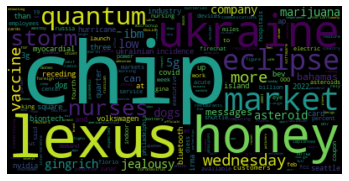

In [5]:
import matplotlib.pyplot as plt
f = open("results/science_logistic-regression_tfidf.json")
most_important_words = json.load(f)
wc = WordCloud()
wc.generate_from_frequencies(most_important_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig("results/Figures/science_logisitic_cloud.png")
plt.show()


In [6]:
#makes intersection of sets, select two topics, what preprocessing, and what model
def topicintersection (topic1, topic2, preproc, model, model2):
    f = open("results/"+ topic1 + "_" + model + "_"  + preproc + ".json")
    set1 = set(json.load(f).keys())
    f2 = open("results/"+ topic2 + "_" + model2 + "_"  + preproc + ".json")
    set2 = set(json.load(f2).keys()) 
    pct_intersect = len(set1.intersection(set2))/len(set2)
    return pct_intersect

TypeError: topicintersection() missing 1 required positional argument: 'model2'

In [8]:
#runs topicintersection for all topics and models, (atm just for tfidf and logistic)
def intersect_all():
    intersections = {}
    for topic in ["general","politics", "economics", "science"]:
        intersections[topic] = {}
        for topic2 in ["general","politics", "economics", "science"]:
            if topic == topic2:
                pass
            else:
                for model in ["logistic-regression", "svm", "decision-tree", "random-forest"]:
                    for model2 in ["logistic-regression", "svm", "decision-tree", "random-forest"]:
                        pct_intersect = topicintersection(topic, topic2, 'tfidf', model, model2)
                        intersections[topic][topic2 + ", tfidf, " + model + ", "+ model2] = pct_intersect
    return intersections


In [27]:
intersections = intersect_all()
intersections

{'general': {'politics, tfidf, logistic-regression, logistic-regression': 0.322,
  'politics, tfidf, logistic-regression, svm': 0.332,
  'politics, tfidf, logistic-regression, decision-tree': 0.048,
  'politics, tfidf, logistic-regression, random-forest': 0.19,
  'politics, tfidf, svm, logistic-regression': 0.324,
  'politics, tfidf, svm, svm': 0.332,
  'politics, tfidf, svm, decision-tree': 0.046,
  'politics, tfidf, svm, random-forest': 0.182,
  'politics, tfidf, decision-tree, logistic-regression': 0.036,
  'politics, tfidf, decision-tree, svm': 0.04,
  'politics, tfidf, decision-tree, decision-tree': 0.538,
  'politics, tfidf, decision-tree, random-forest': 0.048,
  'politics, tfidf, random-forest, logistic-regression': 0.206,
  'politics, tfidf, random-forest, svm': 0.214,
  'politics, tfidf, random-forest, decision-tree': 0.048,
  'politics, tfidf, random-forest, random-forest': 0.304,
  'economics, tfidf, logistic-regression, logistic-regression': 0.386,
  'economics, tfidf, log

In [30]:
int_list = list(sorted(intersections["general"].items(), key=lambda item: item[1]))
int_list_top = int_list[:5]
int_list_bottom = int_list[-5:]


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

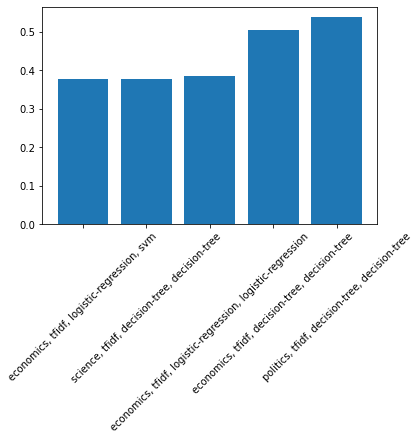

In [39]:
plt.bar([key[0] for key in int_list_bottom], [key[1] for key in int_list_bottom])
plt.xticks(rotation = 45)